In [1]:
import os, os.path
from whoosh import index
from whoosh.fields import *

if not os.path.exists("indexdir"):
    os.mkdir("indexdir")
    
schema = Schema(id = NUMERIC(stored=True), content=TEXT)
ix = index.create_in("indexdir", schema=schema, indexname="usages")
#ix = index.open_dir("indexdir", indexname="usages")
writer = ix.writer()

exists = index.exists_in("indexdir")
usages_exists = index.exists_in("indexdir", indexname="usages")

In [2]:
#example of adding different documents, don't forget to commit!
#writer.add_document(id=1, content=u"This is my document!")
#writer.add_document(id=2, content=u"This is the second example.")
#writer.add_document(id=3, content=u"Examples are many.")
#writer.commit()


In [3]:
#1.1
documents = open('pri_cfc.txt', 'r').read().lower().split('\n')
for document in documents:
    ident = document.split(' ')[0]
    cont = document[len(ident)+1:]
    #print(ident)
    if ident != '':
        writer.add_document(id=int(ident), content=cont)
writer.commit()  
#lets see if all the documents are there
#for i in ix.searcher().documents():
#    print(i)

In [39]:
#1.2
from whoosh.qparser import *
def search_index (query):
    ix = index.open_dir("indexdir", indexname="usages")
    with ix.searcher() as searcher:
        q = QueryParser("content",ix.schema,group=OrGroup).parse(query)#u"the significance") 
        results = searcher.search(q,  limit=None)
        #getting the matches
        res_list = [r.values()[0] for r in results]
        return res_list
print(search_index(u"the significance"))

[157, 402, 809, 74, 412, 593, 78, 555, 923, 319, 485, 223, 195, 355, 1, 147, 858, 121, 179, 205, 526, 411, 631, 1150, 185, 258]


In [86]:
#2.1
def evaluate (retrieved, relevant):
    relevant_retrieved = [i for i in retrieved if i in relevant]
    Precision = len(relevant_retrieved) / len(retrieved)
    Recall = len(relevant_retrieved) / len(relevant)
    #the weighted harmonic mean of precision and recall
    F_Score = 2 * ((Precision * Recall) / (Precision + Recall))
    return Precision, Recall, F_Score


In [87]:
#2.2

documents = open('pri_queries.txt', 'r').read().lower().split('\n')
relevant = [i.split(' ') for i in documents[1::2]] 
relevant_int, results_precision, results_recall, results_f_score=[],[],[],[]
for i in relevant:
    relevant_int.append([int(s) for s in i])
query_pairs = [list(x) for x in zip(*[documents[::2],relevant_int])] 

for pair in query_pairs:
    
    Precision, Recall, F_Score = evaluate(search_index(pair[0]),pair[1])
    results_precision.append(Precision)
    results_recall.append(Recall)
    results_f_score.append(F_Score)
results =[results_precision, results_recall, results_f_score]

#import pprint
#pp = pprint.PrettyPrinter(indent=4)
#pp.pprint(results)


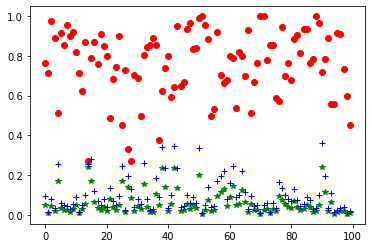

In [92]:
import matplotlib.pyplot as plt
plt.plot(results[0],'g*', results[1], 'ro', results[2], 'b+')
plt.show()

##3

Q yielded => set R = {d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20}

di where i is odd where judged as relevant: [1,3,5...]

di where i is even where judged not relevant: [2,4,6...]

So, relevant documents:
R = {d1,d3,d5,d7,d9,d11,d13,d15,d17,d19}


(a) Precision@5;

(precision at the 5th retrieved document) = 3/5 
number of documents that are relevant until then or precision of top k results

(b) R-precision;

(precision at the Rth document, where R is the number of relevant documents) = Precision@10 = 5/10 = 0.5


(c) The interpolated precision and recall curve.

For each percentage of the set R calculate the precision of that section:

| Re | Pr  |
| --- | --- |
| 0.00 | 1/1 = 1.00 |
| 0.10 | 1/1 = 1.00 |
| 0.20 | 2/3 = 0.67 |
| 0.30 | 3/5 = 0.60 |
| 0.40 | 4/7 = 0.57 |
| 0.50 | 5/9 = 0.56 |
| 0.60 | 6/11 = 0.55 |
| 0.70 | 7/13 = 0.54 |
| 0.80 | 8/15 = 0.53 |
| 0.90 | 9/17 = 0.53 |
| 1.00 | 10/19 = 0.53 |



/Users/joaotiago/opt/anaconda3/envs/PRI/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


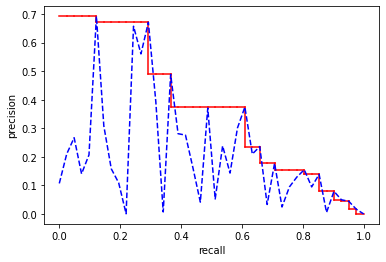

In [108]:
#this is just an example on how to graph it

import numpy as np
#plt.plot([1,1,0.67,0.60,0.57,0.56,0.55,0.54,0.53,0.53,0.53],'gx')

#just a dummy sample
recall=np.linspace(0.0,1.0,num=42)
precision=np.random.rand(42)*(1.-recall)
precision2=precision.copy()
i=recall.shape[0]-2

# interpolation...
while i>=0:
    if precision[i+1]>precision[i]:
        precision[i]=precision[i+1]
    i=i-1

# plotting...
fig, ax = plt.subplots()
for i in range(recall.shape[0]-1):
    ax.plot((recall[i],recall[i]),(precision[i],precision[i+1]),'k-',label='',color='red') #vertical
    ax.plot((recall[i],recall[i+1]),(precision[i+1],precision[i+1]),'k-',label='',color='red') #horizontal

ax.plot(recall,precision2,'k--',color='blue')
#ax.legend()
ax.set_xlabel("recall")
ax.set_ylabel("precision")
fig.show()